In [1]:
import pandas as pd
import numpy as np

from datetime import datetime, date, time, timedelta
import calendar as c         # c is the module
c.setfirstweekday(c.SUNDAY)  # first day Sunday America not Monday Euro
cc = c.Calendar()            # cc is the an instantiation of the class Calendar; class Calendar inside module c

from dateutil.relativedelta import *
from dateutil.rrule import *
from dateutil.parser import *


from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set(style='darkgrid')

import copy

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### Read in the prepped data

In [2]:
df = pd.read_csv('../data/df.csv')

In [3]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))

In [23]:
df.head(3)

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,year,updated_on,latitude,longitude,location,district_x,sector,beat_x,beat_num,district_name,weekday,fri_sat_sun
0,8926266,HV598372,2012-11-15 00:01:00,013XX W CORNELIA AVE,0810,THEFT,OVER $500,APARTMENT,False,False,1924,19.0,44.0,6.0,06,2012,02/10/2018 03:50:01 PM,41.945267,-87.662672,"(41.945267201, -87.662671562)",19.0,2.0,2.0,1924.0,Town Hall,Thursday,0
1,8888158,HV562478,2012-11-15 00:01:00,122XX S PRINCETON AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,523,5.0,34.0,53.0,14,2012,02/10/2018 03:50:01 PM,41.671987,-87.629693,"(41.67198685, -87.629693199)",5.0,2.0,2.0,523.0,Calumet,Thursday,0
2,8888176,HV562494,2012-11-15 00:01:00,012XX N PULASKI RD,0460,BATTERY,SIMPLE,SIDEWALK,False,False,2534,25.0,27.0,23.0,08B,2012,02/10/2018 03:50:01 PM,41.902899,-87.726309,"(41.902899152, -87.72630861)",25.0,3.0,3.0,2534.0,Grand Central,Thursday,0


#### Maybe day-of-week means something...

In [24]:
df['weekday'] = df['date'].apply(lambda x: c.day_name[x.weekday()])

In [25]:
df['weekday'].value_counts(normalize= True)

Friday       0.150572
Saturday     0.145129
Monday       0.141755
Thursday     0.141632
Wednesday    0.141387
Tuesday      0.140584
Sunday       0.138941
Name: weekday, dtype: float64

#### Friday and Saturday lead the pack, but not a breakaway at eyeballs glance.    Check if it's more pronounced when looking at specific crime types, or perhaps by area (aka police district)

In [26]:
df.groupby(['primary_type'])['weekday'].value_counts()

primary_type                       weekday  
ARSON                              Saturday       455
                                   Sunday         444
                                   Tuesday        433
                                   Monday         418
                                   Friday         414
                                   Wednesday      401
                                   Thursday       352
ASSAULT                            Wednesday    19302
                                   Thursday     19227
                                   Tuesday      19047
                                   Monday       18888
                                   Friday       18748
                                   Sunday       17963
                                   Saturday     17700
BATTERY                            Sunday       60515
                                   Saturday     56516
                                   Friday       48855
                                   Mo

#### Sifting through, the Friday-Saturday-Sunday stands out when it comes to VIOLENT crimes;  for Battery (it's not even close!),  Homicide (not even close!), Robbery, Weapons Violations, Criminal Damage, Criminal Sexual Assault, Concealed Carry (very low numbers on that type, however), Motor Vehicle Theft,  they lead by far.   
#### If looking to predict VIOLENT crime,  it must be considered

#### On the flip side,  Fri-Sat-Sun do basement dwelling on Assault (verbal but not physical attack), Burglary (harder to do when people are at home from work??), Deceptive Practices (Fri high but nose dives Sat-Sun;  forged documents and checks,  illicit credit and ATM cards, identity theft,  computer fraud, con games;  fraudsters in force on Friday but then take the rest of the weekend off seemingly)
#### Theft does a bookends job --- high on Fri, average on Sat, tanks Sun

In [27]:
df.groupby(['district_name'])['weekday'].value_counts(normalize= True)

district_name   weekday  
Albany Park     Friday       0.149789
                Monday       0.145724
                Thursday     0.144079
                Wednesday    0.143710
                Tuesday      0.142601
                Saturday     0.139109
                Sunday       0.134988
Austin          Friday       0.149171
                Saturday     0.144766
                Wednesday    0.142458
                Monday       0.141763
                Sunday       0.141180
                Thursday     0.140498
                Tuesday      0.140163
Calumet         Monday       0.146526
                Friday       0.145773
                Saturday     0.143890
                Wednesday    0.142983
                Tuesday      0.140900
                Thursday     0.140359
                Sunday       0.139570
Central         Friday       0.159170
                Thursday     0.149600
                Tuesday      0.145701
                Wednesday    0.145376
                Monday  

#### What seems most striking isn't that Friday is a big deal in most districts,  but the SPREAD between highest to lowest days within a district.   Near North is the king of swing from 0.1782 Fri to 0.1234 Tuesday.   Central (aka  Loop) also has a bigger spread.  

### Friday-Saturday-Sunday has promise as a  good variable to track for so many possible end users,  so add it to the dataframe

##### End users could include CPD shift schedulers, general citizens, businesses including hospitality, tourists

In [28]:
def fri_sat_sun(d):
    return int((d == 'Friday') | (d == 'Saturday') | (d == 'Sunday'))

df['fri_sat_sun'] = df['weekday'].apply(fri_sat_sun)

### Plot a visual that shows the Friday-Saturday-Sunday crimes that are above the null case 

In [29]:
df_fss = df.groupby(['primary_type'])['fri_sat_sun'].value_counts(normalize= True).to_frame()

##### 8 cases of  'NON-CRIMINAL (SUBJECT SPECIFIED)' occurred out of over 1.9 million cases in 7 years,  and all 8 occurred on Mondays, Wednesdays, or Thursdays;   since there is nothing to plot for them, they will be deleted for this plot

In [30]:
# keep safe the true dataset;  to delete for this plot use a deep copied throwaway temp
temp   = copy.deepcopy(df)
temp   = temp[temp['primary_type'] != 'NON-CRIMINAL (SUBJECT SPECIFIED)']
df_fss = temp.groupby(['primary_type'])['fri_sat_sun'].value_counts(normalize= True).to_frame()

In [31]:
constructor_list = []
for item in df_fss.iloc[df_fss.index.get_level_values('fri_sat_sun') == 1].values.tolist():
    constructor_list.append(item[0])

In [32]:
df_for_seaborn = pd.DataFrame({'primary_type': sorted(list(set(df_fss.index.get_level_values('primary_type')))),
                          'fri_sat_sun_pct': constructor_list})
df_for_seaborn = df_for_seaborn.sort_values(by= 'fri_sat_sun_pct')

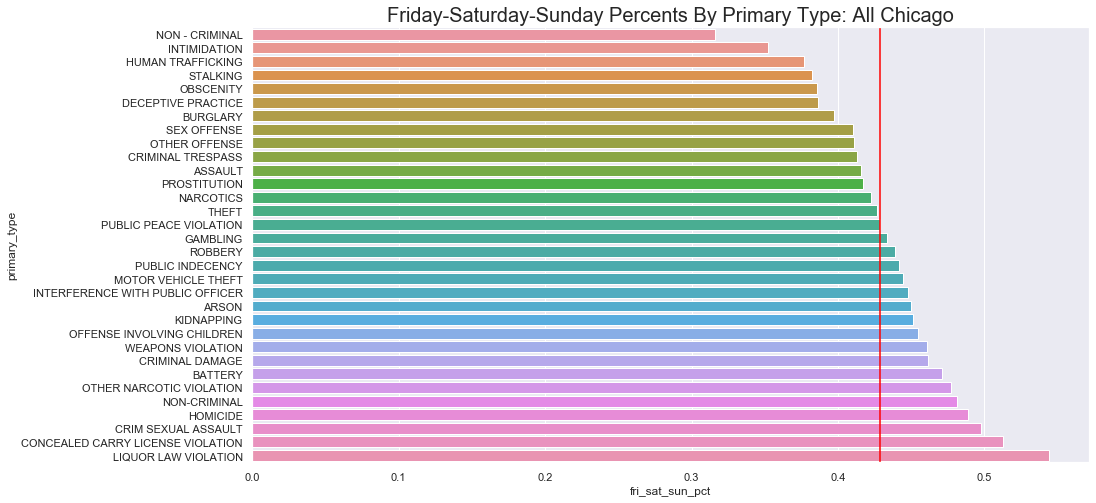

In [33]:
fig = plt.figure(figsize= (15, 8))
ax = fig.add_subplot(1,1,1)
sns.barplot(y= 'primary_type', x= 'fri_sat_sun_pct', data= df_for_seaborn)
plt.axvline(0.4286, color= 'red')
ax.set_title('Friday-Saturday-Sunday Percents By Primary Type: All Chicago', fontsize= 20)
fig.savefig('../assets/fss_pct_all_chicago.png')

### Plot a visual for Near North district (which has the largest  swing with M-T-W-Th)

In [34]:
df_near_north = df[df['district_name'] == 'Near North']

##### 1 case of  'HUMAN TRAFFICKING' occurred in Near North district over 7 years and it happened on a Thursday;  nothing to plot so it'll be dropped for this plot;  'NON-CRIMINAL' also like above

In [35]:
# keep true dataset safe;  use a throwaway temp for this plot
temp   = df[df['district_name'] == 'Near North']
temp   = temp[temp['primary_type'] != 'HUMAN TRAFFICKING']
temp   = temp[temp['primary_type'] != 'NON-CRIMINAL']
temp   = temp[temp['primary_type'] != 'NON - CRIMINAL']
df_fss = temp.groupby(['primary_type'])['fri_sat_sun'].value_counts(normalize= True).to_frame()

In [36]:
constructor_list = []
for item in df_fss.iloc[df_fss.index.get_level_values('fri_sat_sun') == 1].values.tolist():
    constructor_list.append(item[0])
    
df_for_seaborn = pd.DataFrame({'primary_type': sorted(list(set(df_fss.index.get_level_values('primary_type')))),
                          'fri_sat_sun_pct': constructor_list})
df_for_seaborn = df_for_seaborn.sort_values(by= 'fri_sat_sun_pct')

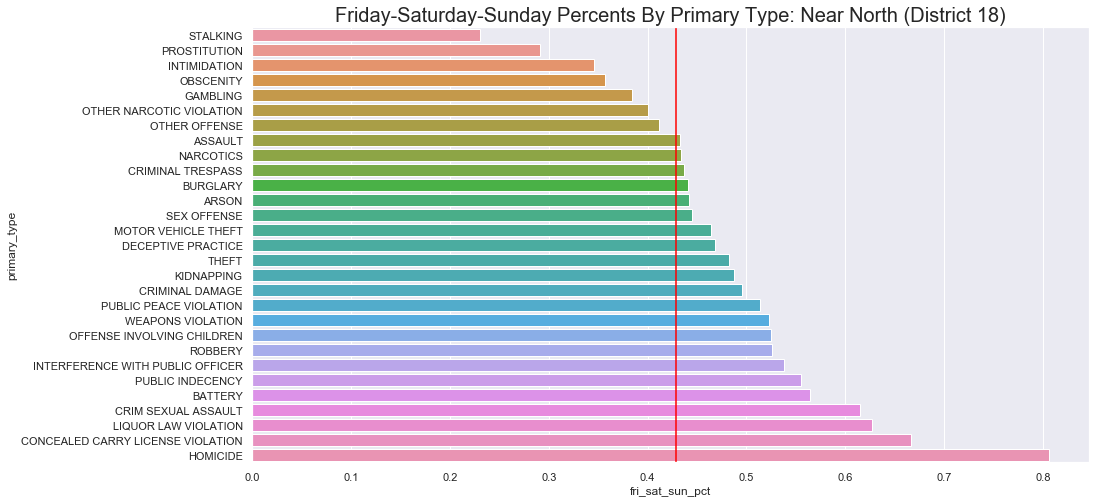

In [37]:
fig = plt.figure(figsize= (15, 8))
ax = fig.add_subplot(1,1,1)
sns.barplot(y= 'primary_type', x= 'fri_sat_sun_pct', data= df_for_seaborn)
plt.axvline(0.4286, color= 'red')
ax.set_title('Friday-Saturday-Sunday Percents By Primary Type: Near North (District 18)', fontsize= 20)
plt.savefig('../assets/fss_pct_near_north.jpg')

## pick up workflow in the next notebook

In [38]:
df.to_csv('../data/df_1.csv', index= False)